In [1]:
# Load the dataset
import pandas as pd
file_path = '../spreadspoke_scores.csv'
data = pd.read_csv(file_path)

In [2]:
homescore_na = data[data['score_home'].isna()].groupby('schedule_season')['score_home'].size()
awayscore_na = data[data['score_away'].isna()].groupby('schedule_season')['score_away'].size()
print(homescore_na)
print(awayscore_na)


schedule_season
2024    208
Name: score_home, dtype: int64
schedule_season
2024    208
Name: score_away, dtype: int64


## Clean Data

In [3]:
# remove post season games
data = data[data['schedule_playoff'] == False]

# remove 2024 season which is missing most scores
data = data[data['schedule_season'] != 2024]

# look at years after 2002 (most recent team, texans, join the nfl)
data = data[data['schedule_season'] >= 2002]

# get desired columns
columns = ['schedule_season','schedule_week','team_home','team_away','score_home','score_away','over_under_line']
data = data[columns]

# change week and over/under line to numeric
data['schedule_week'] = data['schedule_week'].astype(int)
data['over_under_line'] = data['over_under_line'].astype(float)

# check for missing values
seasonNA = data.dropna(subset=['schedule_season'])
weekNA = data.dropna(subset=['schedule_week'])
thomeNA = data.dropna(subset=['team_home'])
tawayNA = data.dropna(subset=['team_away'])
shomeNA = data.dropna(subset=['score_home'])
sawayNA = data.dropna(subset=['score_away'])
ouNA = data.dropna(subset=['over_under_line'])

print(data.shape[0])
for dset in [seasonNA,weekNA,thomeNA,tawayNA,shomeNA,sawayNA,ouNA]:
    print(dset.shape[0])

5679
5679
5679
5679
5679
5679
5679
5679


In [4]:
for col in data.columns:
    print(col," ",data[col].dtype)

schedule_season   int64
schedule_week   int64
team_home   object
team_away   object
score_home   float64
score_away   float64
over_under_line   float64


# Observe Feature Correlations

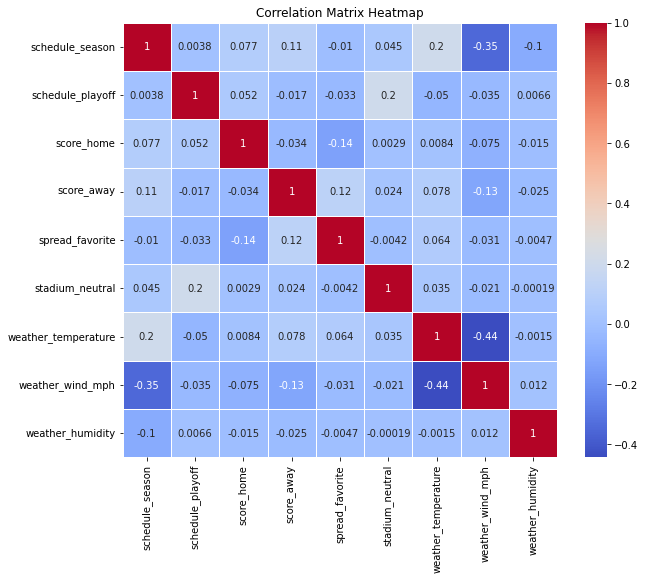

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data from a CSV file
# Replace 'your_file.csv' with the path to your actual CSV file
data_full = pd.read_csv('../spreadspoke_scores.csv')

# Drop any columns that are unnamed or unnecessary
data_full = data_full.loc[:, ~data_full.columns.str.contains('^Unnamed')]

# Compute the correlation matrix
corr_matrix = data_full.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True, linewidths=.5)

# Display the plot
plt.title('Correlation Matrix Heatmap')
plt.show()


# Format data

In [6]:
# generate points scored and points allowed dict for every season
'''
seasons<dict> = {year<dict>:(points_scored<dict>,points_allowed<dict>,num_weeks<int>)}
points_[scored/allowed] = {team<String>: scores<List<int>>}
'''

seasons = {}
for year in range(1966,2024):
    num_weeks = data[data['schedule_season'] == year]['schedule_week'].max()
    points_scored = {}
    points_allowed = {}
    teams = data[data["schedule_season"] == year]['team_home'].unique()
    for team in teams:
        scored = []
        allowed = []
        for week in range(1,num_weeks+1):
            is_home = not(data[(data['schedule_season'] == year) & (data['team_home'] == team) & (data['schedule_week'] == week)].empty)
            is_away = not(data[(data['schedule_season'] == year) & (data['team_away'] == team) & (data['schedule_week'] == week)].empty)
            try:
                if is_home:
                    scored.append(int(data[(data['schedule_season'] == year) & (data['team_home'] == team) & (data['schedule_week'] == week)]['score_home']))
                    allowed.append(int(data[(data['schedule_season'] == year) & (data['team_home'] == team) & (data['schedule_week'] == week)]['score_away']))
                elif is_away:
                    scored.append(int(data[(data['schedule_season'] == year) & (data['team_away'] == team) & (data['schedule_week'] == week)]['score_away']))
                    allowed.append(int(data[(data['schedule_season'] == year) & (data['team_away'] == team) & (data['schedule_week'] == week)]['score_home']))
                else:
                    scored.append("bye")
                    allowed.append("bye")
            except:
                print(year," ",team," ",week)
                print(data[(data['schedule_season'] == year) & (data['team_away'] == team) & (data['schedule_week'] == week)]['score_away'])
                break
        points_scored[team] = scored
        points_allowed[team] = allowed
    seasons[year] = (points_scored,points_allowed,num_weeks)



# Calculate Mean Absolute Error for each test

In [7]:
import statistics as stat
TEAM1 = 0
TEAM2 = 1

'''
1: avg(team1_scored) + avg(team2_scored)
2: avg(team1_allowed) + avg(team2_allowed)
3: avg(team1_scored<last n>) + avg(team2_scored<last n>)
4: avg(team1_allowed<last n>) + avg(team2_allowed<last n>)
'''
def avg_points(match,points_dict,week,last_n=None,returnVal=None):
    if last_n == None: last_n = week

    t1_past_points = points_dict[match[TEAM1]][:week]
    team1_points = [points for points in t1_past_points[-1*last_n:] if points != "bye"]
    team1_points = stat.mean(team1_points)

    t2_past_points = points_dict[match[TEAM2]][:week]
    team2_points = [points for points in t2_past_points[-1*last_n:] if points != "bye"]
    team2_points = stat.mean(team2_points)

    t1_actual = points_dict[match[TEAM1]][week]
    t2_actual = points_dict[match[TEAM2]][week]

    if returnVal == "MAE": return abs((team1_points + team2_points) - (t1_actual + t2_actual))
    elif returnVal == "combScore": return team1_points + team2_points
    else: raise ValueError

'''
1:
adjust1 = (avg(team1_scored) + avg(team2_allowed))/2
adjust2 = (avg(team2_scored) + avg(team1_allowed))/2
adjust1 + adjust2

2:
adjust1 = (avg(team1_scored<last n>) + avg(team2_allowed<last n>))/2
adjust2 = (avg(team2_scored<last n>) + avg(team1_allowed<last n>))/2
adjust1 + adjust2
'''
def adjusted(match,points_scored,points_allowed,week,last_n=None,returnVal=None):
    if last_n == None: last_n = week

    t1_past_scored = points_scored[match[TEAM1]][:week]
    team1_scored = [points for points in t1_past_scored[-1*last_n:] if points != "bye"]
    team1_scored = stat.mean(team1_scored)

    t2_past_scored = points_scored[match[TEAM2]][:week]
    team2_scored = [points for points in t2_past_scored[-1*last_n:] if points != "bye"]
    team2_scored = stat.mean(team2_scored)

    t1_past_allowed = points_allowed[match[TEAM1]][:week]
    team1_allowed = [points for points in t1_past_allowed[-1*last_n:] if points != "bye"]
    team1_allowed = stat.mean(team1_allowed)

    t2_past_allowed = points_allowed[match[TEAM2]][:week]
    team2_allowed = [points for points in t2_past_allowed[-1*last_n:] if points != "bye"]
    team2_allowed = stat.mean(team2_allowed)

    adjust1 = stat.mean([team1_scored,team2_allowed])
    adjust2 = stat.mean([team2_scored,team1_allowed])

    t1_actual = points_scored[match[TEAM1]][week]
    t2_actual = points_scored[match[TEAM2]][week]

    if returnVal == "MAE": return abs((adjust1 + adjust2) - (t1_actual + t2_actual))
    elif returnVal == "combScore": return adjust1 + adjust2
    else: raise ValueError

In [8]:
LAST_N = 3
SCORED_DICT = 0
ALLOWED_DICT = 1
NUM_WEEKS_IDX = 2

t1_diffs = []
t2_diffs = []
t3_diffs = []
t4_diffs = []
t5_diffs = []
t6_diffs = []

for year in range(2002,2024):
    num_weeks = seasons[year][NUM_WEEKS_IDX]
    points_scored = seasons[year][SCORED_DICT]
    points_allowed = seasons[year][ALLOWED_DICT]
    for week_natural in range(4,num_weeks):
        week = week_natural - 1
        week_data = data[(data['schedule_season'] == year) & (data['schedule_week'] == week_natural)]
        matches = list(zip(week_data['team_home'], week_data['team_away']))
        for match in matches:
            t1_diffs.append(avg_points(match,points_scored,week,returnVal="MAE"))
            t2_diffs.append(avg_points(match,points_allowed,week,returnVal="MAE"))
            t3_diffs.append(avg_points(match,points_scored,week,last_n=LAST_N,returnVal="MAE"))
            t4_diffs.append(avg_points(match,points_allowed,week,last_n=LAST_N,returnVal="MAE"))
            t5_diffs.append(adjusted(match,points_scored,points_allowed,week,returnVal="MAE"))
            t6_diffs.append(adjusted(match,points_scored,points_allowed,week,last_n=LAST_N,returnVal="MAE"))

In [9]:
print(stat.mean(t1_diffs))
print(stat.mean(t2_diffs))
print(stat.mean(t3_diffs))
print(stat.mean(t4_diffs))
print(stat.mean(t5_diffs))
print(stat.mean(t6_diffs))

11.453386498576785
12.04728793205912
12.51101253015799
13.048992139466106
10.965254633749264
11.44176589617869


# Analyze over/under performance

In [10]:
WIN = 0
LOSS = 1
PUSH = 2

TEST_SCORE4 = 6
TEST_SCORE6 = 7
TEST_OVERALL = 8

overs = 0
unders = 0
pushes = 0

test_WL = [[0,0,0] for _ in range(9)]

def win_loss(predicted,actual,line,test):
    if actual == line: 
        test_WL[test][PUSH] += 1
    elif (actual < line and predicted < line) or (actual > line and predicted > line):
        test_WL[test][WIN] += 1
    else:
        test_WL[test][LOSS] += 1
    
    if predicted < line: return -1
    elif predicted > line: return 1
    else: return 0

'''
Stats:
w/l for each test
w/l for scores 4 and 6
w/l for combined 4s and 6s
'''
for year in range(2002,2024):
    num_weeks = seasons[year][NUM_WEEKS_IDX]
    points_scored = seasons[year][SCORED_DICT]
    points_allowed = seasons[year][ALLOWED_DICT]
    for week_natural in range(4,num_weeks):
        week = week_natural - 1
        week_data = data[(data['schedule_season'] == year) & (data['schedule_week'] == week_natural)]
        matches = list(zip(week_data['team_home'], week_data['team_away']))
        for match in matches:
            match_data = week_data[(week_data['team_home'] == match[0]) & (week_data['team_away'] == match[1])]
            line = float(match_data['over_under_line'])
            actual = int(match_data['score_home']) + int(match_data['score_away'])
            t1_score = avg_points(match,points_scored,week,returnVal="combScore")
            t2_score = avg_points(match,points_allowed,week,returnVal="combScore")
            t3_score = avg_points(match,points_scored,week,last_n=3,returnVal="combScore")
            t4_score = avg_points(match,points_allowed,week,last_n=3,returnVal="combScore")
            t5_score = adjusted(match,points_scored,points_allowed,week,last_n=3,returnVal="combScore")
            t6_score = adjusted(match,points_scored,points_allowed,week,last_n=3,returnVal="combScore")

            test_score = 0
            for test,score in enumerate([t1_score,t2_score,t3_score,t4_score,t5_score,t6_score]):
                test_score += win_loss(score,actual,line,test)

            test = None
            if abs(test_score) == 4: test = TEST_SCORE4
            elif abs(test_score) == 6: test = TEST_SCORE6
            else: continue

            if actual == line:
                test_WL[test][PUSH] += 1
                test_WL[TEST_OVERALL][PUSH] += 1
            elif (actual > line and test_score > 0) or (actual < line and test_score < 0):
                test_WL[test][WIN] += 1
                test_WL[TEST_OVERALL][WIN] += 1
            else:
                test_WL[test][LOSS] += 1
                test_WL[TEST_OVERALL][LOSS] += 1

            if actual > line:
                overs += 1
            elif actual < line:
                unders += 1
            else:
                pushes += 1

            

In [11]:
def win_pct(test_num):
    return round(100*test_WL[test_num][WIN]/(test_WL[test_num][WIN]+test_WL[test_num][LOSS]),2)

for i in range(6):
    print(f"test {i+1}: {test_WL[i][WIN]}-{test_WL[i][LOSS]}-{test_WL[i][PUSH]} ({win_pct(i)}%)")
print(f"test score 4: {test_WL[6][WIN]}-{test_WL[6][LOSS]}-{test_WL[6][PUSH]} ({win_pct(6)}%)")
print(f"test score 6: {test_WL[7][WIN]}-{test_WL[7][LOSS]}-{test_WL[7][PUSH]} ({win_pct(7)}%)")
print(f"test overall: {test_WL[8][WIN]}-{test_WL[8][LOSS]}-{test_WL[8][PUSH]} ({win_pct(8)}%)")

test 1: 2105-2106-72 (49.99%)
test 2: 2032-2179-72 (48.25%)
test 3: 2105-2106-72 (49.99%)
test 4: 2090-2121-72 (49.63%)
test 5: 2074-2137-72 (49.25%)
test 6: 2074-2137-72 (49.25%)
test score 4: 653-620-16 (51.3%)
test score 6: 294-318-11 (48.04%)
test overall: 947-938-27 (50.24%)


In [12]:
print(f"num over:   {overs} ({round(100*overs/(overs+unders),2)}%)")
print(f"num unders: {unders} ({round(100*unders/(overs+unders),2)}%)")
print(f"num pushes: {pushes}")

num over:   927 (49.18%)
num unders: 958 (50.82%)
num pushes: 27


# Over/Under dominance by part of the season

In [13]:
# check to see if over or under is more dominant in each quarter of the season
Q1 = 0
Q2 = 1
Q3 = 2
Q4 = 3
OVERS = 0
UNDERS = 1
PUSHES = 2

def calc_quarter_stats(year,start_week,end_week,qnum):
    overs = 0
    unders = 0
    pushes = 0
    for week_natural in range(start_week,end_week):
        week = week_natural - 1
        week_data = data[(data['schedule_season'] == year) & (data['schedule_week'] == week_natural)]
        matches = list(zip(week_data['team_home'], week_data['team_away']))
        for match in matches:
            match_data = week_data[(week_data['team_home'] == match[0]) & (week_data['team_away'] == match[1])]
            line = float(match_data['over_under_line'])
            actual = int(match_data['score_home']) + int(match_data['score_away'])
            if line > actual: overs += 1
            elif line < actual: unders += 1
            else: pushes += 1
    print(f"{year} season | Quarter #{qnum}")
    print(f"\tovers: {overs}({round(overs/(overs+unders),4)}%)")
    print(f"\tunders: {unders}({round(unders/(overs+unders),4)}%)")
    print(f"\tpushes: {pushes}")
    print()

    return overs,unders,pushes

quarter_stats = [[0,0,0] for _ in range(4)]
for year in range(2002,2024):
    num_weeks = seasons[year][NUM_WEEKS_IDX]
    # Q1
    o1,u1,p1 = calc_quarter_stats(year,0,int(num_weeks//4)+1,1)
    quarter_stats[Q1][OVERS] += o1
    quarter_stats[Q1][UNDERS] += u1
    quarter_stats[Q1][PUSHES] += p1
    # Q2
    o2,u2,p2 = calc_quarter_stats(year,int(num_weeks//4)+1,int(num_weeks//2)+1,2)
    quarter_stats[Q2][OVERS] += o2
    quarter_stats[Q2][UNDERS] += u2
    quarter_stats[Q2][PUSHES] += p2
    # Q3
    o3,u3,p3 = calc_quarter_stats(year,int(num_weeks//2)+1,int((num_weeks*1.5)//2)+1,3)
    quarter_stats[Q3][OVERS] += o3
    quarter_stats[Q3][UNDERS] += u3
    quarter_stats[Q3][PUSHES] += p3
    # Q4
    o4,u4,p4 = calc_quarter_stats(year,int((num_weeks*1.5)//2)+1,int(num_weeks),4)
    quarter_stats[Q4][OVERS] += o4
    quarter_stats[Q4][UNDERS] += u4
    quarter_stats[Q4][PUSHES] += p4
    print(int(num_weeks//4),int(num_weeks//2),int((num_weeks*1.5)//2),num_weeks)
    

2002 season | Quarter #1
	overs: 27(0.4576%)
	unders: 32(0.5424%)
	pushes: 1

2002 season | Quarter #2
	overs: 26(0.4727%)
	unders: 29(0.5273%)
	pushes: 1

2002 season | Quarter #3
	overs: 34(0.5763%)
	unders: 25(0.4237%)
	pushes: 1

2002 season | Quarter #4
	overs: 28(0.4375%)
	unders: 36(0.5625%)
	pushes: 0

4 8 12 17
2003 season | Quarter #1
	overs: 34(0.5763%)
	unders: 25(0.4237%)
	pushes: 1

2003 season | Quarter #2
	overs: 26(0.4643%)
	unders: 30(0.5357%)
	pushes: 0

2003 season | Quarter #3
	overs: 28(0.4912%)
	unders: 29(0.5088%)
	pushes: 3

2003 season | Quarter #4
	overs: 33(0.5156%)
	unders: 31(0.4844%)
	pushes: 0

4 8 12 17
2004 season | Quarter #1
	overs: 36(0.6%)
	unders: 24(0.4%)
	pushes: 0

2004 season | Quarter #2
	overs: 23(0.4182%)
	unders: 32(0.5818%)
	pushes: 1

2004 season | Quarter #3
	overs: 30(0.5085%)
	unders: 29(0.4915%)
	pushes: 1

2004 season | Quarter #4
	overs: 31(0.4844%)
	unders: 33(0.5156%)
	pushes: 0

4 8 12 17
2005 season | Quarter #1
	overs: 34(0.60

In [14]:
print(f"OVERALL")
for quarter in range(4):
    print(f"\tQuarter #{quarter+1} of the season:")
    q_over = quarter_stats[quarter][OVERS]
    q_under = quarter_stats[quarter][UNDERS]
    print(f"\t\tovers: {q_over}({round((q_over*100)/(q_over+q_under),2)}%)")
    print(f"\t\tunders: {q_under}({round((q_under*100)/(q_over+q_under),2)}%)")
    print(f"\t\tpushes: {quarter_stats[quarter][PUSHES]}")
print()

OVERALL
	Quarter #1 of the season:
		overs: 678(50.75%)
		unders: 658(49.25%)
		pushes: 31
	Quarter #2 of the season:
		overs: 636(50.48%)
		unders: 624(49.52%)
		pushes: 18
	Quarter #3 of the season:
		overs: 648(51.51%)
		unders: 610(48.49%)
		pushes: 25
	Quarter #4 of the season:
		overs: 714(51.85%)
		unders: 663(48.15%)
		pushes: 22

